In [1]:
import numpy as np
import pandas as pd
from scipy import stats

Уровень кальция в крови здоровых молодых женщин равен в среднем 9.5 милиграммам на децилитр и имеет характерное стандартное отклонение 0.4 мг/дл. В сельской больнице Гватемалы для 160 здоровых беременных женщин при первом обращении для ведения беременности был измерен уровень кальция; среднее значение составило 9.57 мг/дл. Можно ли утверждать, что средний уровень кальция в этой популяции отличается от 9.5?

Посчитайте достигаемый уровень значимости. Поскольку известны только среднее и дисперсия, а не сама выборка, нельзя использовать стандартные функции критериев — нужно реализовать формулу достигаемого уровня значимости самостоятельно.

Округлите ответ до четырёх знаков после десятичной точки.

Сначала нужно посчитать значение z-статистики самостоятельно по формуле:
$Z = \frac{(\bar{X}-\mu_0) * \sqrt{n}}{\sigma}$

In [2]:
mu = 9.5
sigma = 0.4
n = 160
x_mean = 9.57

In [3]:
z = (x_mean - mu)*np.sqrt(n)/sigma

Примем нулевую гипотезу: $H_0: \mu_0 \ne \mu$. Значит нужно использовать двустороннюю альтернативу

$p = 2(1 - F_{N(0,1)}(|z|))$

In [5]:
abs_z = abs(z)

In [8]:
p = 2*(1 - stats.norm.cdf(abs_z))

In [9]:
print(p)

0.026856695507523787


Получается, нулевая гипотеза несостоятельна на уровне значимости $\alpha = 0.05$

Отделите 25% случайных наблюдений в тестовую выборку с помощью функции sklearn.cross_validation.train_test_split (зафиксируйте random state = 1). На обучающей выборке настройте две регрессионные модели:

линейную регрессию с помощью LinearRegression без параметров
случайный лес из 10 деревьев с помощью RandomForestRegressor с random_state=1.
Какая из моделей лучше предсказывает цену бриллиантов? Сделайте предсказания на тестовой выборке, посчитайте модули отклонений предсказаний от истинных цен. Проверьте гипотезу об одинаковом среднем качестве предсказаний, вычислите достигаемый уровень значимости. Отвергается ли гипотеза об одинаковом качестве моделей против двусторонней альтернативы на уровне значимости \alpha=0.05α=0.05?

In [12]:
data = pd.read_csv('diamonds.txt', delimiter='\t')

In [14]:
data.head()

,carat,depth,table,price,x,y,z
0,0.23,61.5,55.0,326,3.95,3.98,2.43
1,0.21,59.8,61.0,326,3.89,3.84,2.31
2,0.23,56.9,65.0,327,4.05,4.07,2.31
3,0.29,62.4,58.0,334,4.20,4.23,2.63
4,0.31,63.3,58.0,335,4.34,4.35,2.75


In [38]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [18]:
x = data.drop('price', axis=1)
y = data.price

In [21]:
np.random.seed(1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)

In [41]:
lin = LinearRegression()
trees = RandomForestRegressor(10, random_state=1)
lin.fit(x_train, y_train)
trees.fit(x_train, y_train)
preds_lin = lin.predict(x_test)
preds_trees = trees.predict(x_test)
print(f'Linear model MAE: {mean_absolute_error(y_test, preds_lin)}')
print(f'Random forest model MAE: {mean_absolute_error(y_test, preds_trees)}')

Linear model MAE: 890.3764004285612
Random forest model MAE: 802.9205172724115


Случайный лес показывает результат чуть лучше.

Модули отклонений предсказаний от истинных цен:

In [42]:
deviation_lin = np.abs(y_test - preds_lin)
deviation_trees = np.abs(y_test - preds_trees)

Проверим гипотезу об одинаковом среднем качестве предсказаний, то есть: $H_0: \mu_{trees} = \mu_{lin}$. То есть альтернатива здесь двухсторонняя.

In [31]:
from matplotlib import pyplot as plt
%matplotlib inline

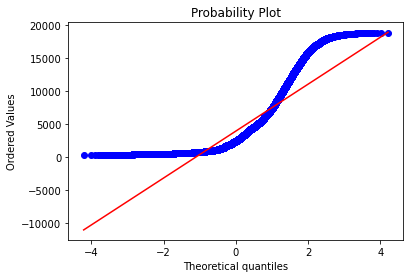

In [43]:
stats.probplot(y, dist="norm", plot=plt)
plt.show()

То есть данные вообще НЕ распределены нормально, ни о каком критерии Стьюдента здесь речь не идёт. Но так как тут пока не понятно, что ещё они могли просить, возьмём его:

In [44]:
stats.ttest_ind(deviation_lin, deviation_trees, equal_var = False)

Ttest_indResult(statistic=6.2054184467870765, pvalue=5.534495566292084e-10)

In [34]:
from statsmodels.stats.weightstats import *

In [45]:
cm = CompareMeans(DescrStatsW(deviation_lin), DescrStatsW(deviation_trees))
print("95%% confidence interval: [%f, %f]" % cm.tconfint_diff(usevar='unequal'))

95% confidence interval: [59.831948, 115.079818]


In [46]:
DescrStatsW(deviation_lin - deviation_trees).tconfint_mean()

(74.2872453259553, 100.62452098634381)